In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install textstat
import numpy as np
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textstat import flesch_reading_ease

# NLTK (Natural Language Toolkit) resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Loads file paths
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';').drop_duplicates().dropna()
    return df

# Preprocess and combine text data for BERT
def preprocess_data(df):
    def clean_text(text):
        text = re.sub(r'http\S+', '', text)
        text = text.lower()
        text = re.sub(r'@\w+', '@user', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if not word in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        clean_text = ' '.join(tokens)
        fre = flesch_reading_ease(clean_text)
        return clean_text, fre
    df[['clean_text', 'flesch_reading_ease']] = df['text'].apply(
        lambda x: pd.Series(clean_text(x)))
    df['combined_text'] = df['screen_name'].astype(str) + " " + df['clean_text']
    return df

In [4]:
# Generate BERT embeddings
def get_bert_embeddings(texts, tokenizer, model, device):
    model.eval()
    model.to(device)
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].detach().cpu().numpy())
    return np.vstack(embeddings)

# Initialize tokenizer and BERT-base-uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
# Load and preprocess data
train_df = load_data('/content/drive/MyDrive/ML/train.csv')
validation_df = load_data('/content/drive/MyDrive/ML/validation.csv')
test_df = load_data('/content/drive/MyDrive/ML/test.csv')
train_df = preprocess_data(train_df)
validation_df = preprocess_data(validation_df)
test_df = preprocess_data(test_df)

# Prepare embeddings and labels
train_texts = train_df['combined_text'].tolist()
validation_texts = validation_df['combined_text'].tolist()
test_texts = test_df['combined_text'].tolist()
train_embeddings = get_bert_embeddings(train_texts, tokenizer, model, device)
validation_embeddings = get_bert_embeddings(validation_texts, tokenizer, model, device)
test_embeddings = get_bert_embeddings(test_texts, tokenizer, model, device)

In [6]:
# Prepare features + Flesch Reading Ease score
def prepare_features(df, embeddings):
    normalized_fre = (df['flesch_reading_ease'] - df['flesch_reading_ease'].mean()) / df['flesch_reading_ease'].std()

    # Combine embeddings w/ normalized Flesch score
    features = np.hstack([embeddings, normalized_fre.values.reshape(-1, 1)])
    return features

train_features = prepare_features(train_df, train_embeddings)
validation_features = prepare_features(validation_df, validation_embeddings)
test_features = prepare_features(test_df, test_embeddings)

In [7]:
# Encode the labels
le = LabelEncoder()
train_labels = le.fit_transform(train_df['account.type'])
validation_labels = le.transform(validation_df['account.type'])
test_labels = le.transform(test_df['account.type'])

# Define base and meta-models (for stacking) for stacking and initialize other ensemble models
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(kernel='linear', probability=True))
]
meta_model = LogisticRegression()

voting_clf = VotingClassifier(estimators=base_models, voting='soft')
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)

In [10]:
# Confusion matrix function
def plot_confusion_matrix(test_labels, predictions, model_name):
    cm = confusion_matrix(test_labels, predictions)
    df_cm = pd.DataFrame(cm, index=[i for i in le.classes_], columns=[i for i in le.classes_])
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='g')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "GaussianNB": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

Evaluating individual models:
LogisticRegression - Test Set Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1280
           1       0.94      0.94      0.94      1278

    accuracy                           0.94      2558
   macro avg       0.94      0.94      0.94      2558
weighted avg       0.94      0.94      0.94      2558



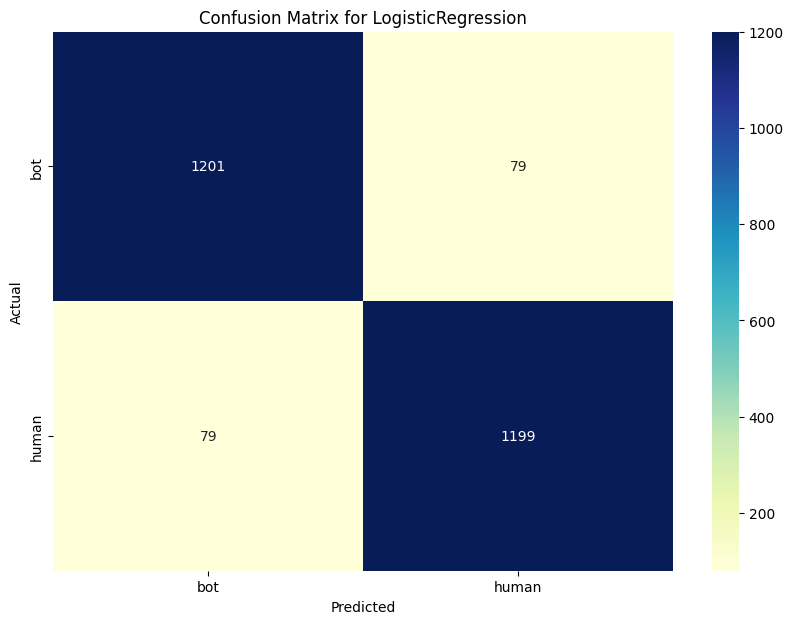

RandomForestClassifier - Test Set Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1280
           1       0.84      0.87      0.85      1278

    accuracy                           0.85      2558
   macro avg       0.85      0.85      0.85      2558
weighted avg       0.85      0.85      0.85      2558



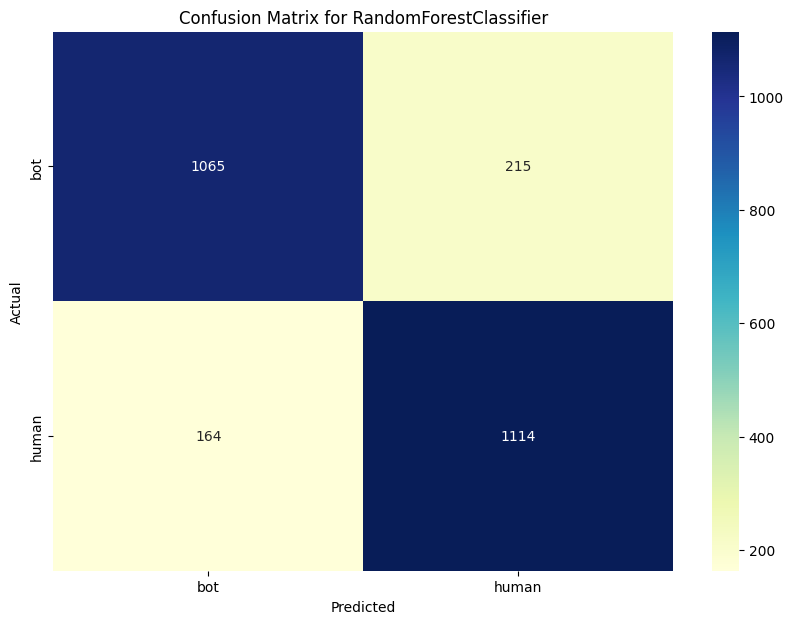

GaussianNB - Test Set Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1280
           1       0.66      0.63      0.65      1278

    accuracy                           0.65      2558
   macro avg       0.66      0.65      0.65      2558
weighted avg       0.66      0.65      0.65      2558



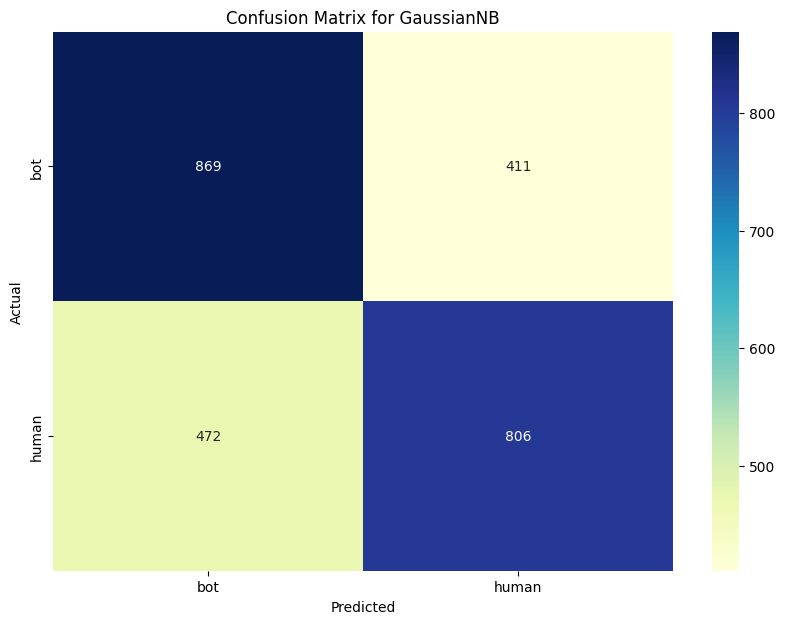

SVM - Test Set Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1280
           1       0.94      0.94      0.94      1278

    accuracy                           0.94      2558
   macro avg       0.94      0.94      0.94      2558
weighted avg       0.94      0.94      0.94      2558



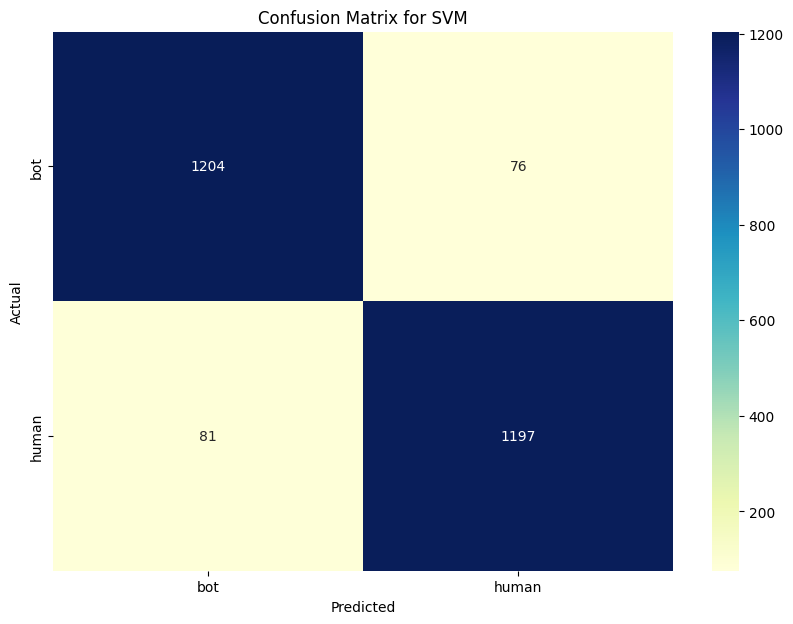

XGBoost - Test Set Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1280
           1       0.90      0.91      0.90      1278

    accuracy                           0.90      2558
   macro avg       0.90      0.90      0.90      2558
weighted avg       0.90      0.90      0.90      2558



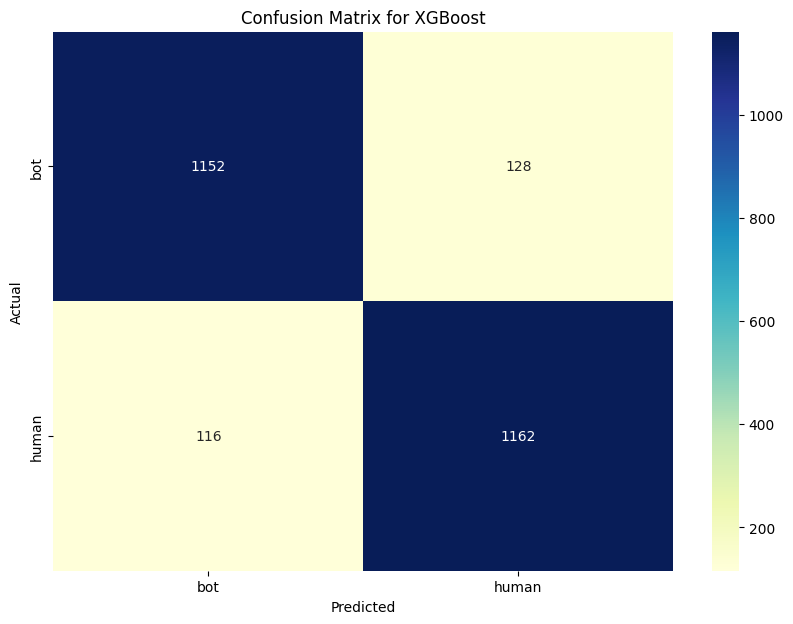

In [11]:
# Individual baseline models
print("Evaluating individual models:")
for name, classifier in classifiers.items():
    classifier.fit(train_features, train_labels)
    test_pred = classifier.predict(test_features)
    print(f"{name} - Test Set Accuracy: {accuracy_score(test_labels, test_pred):.2f}")
    print(classification_report(test_labels, test_pred))
    plot_confusion_matrix(test_labels, test_pred, name)

Evaluating ensemble models:
Voting - Test Set Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1280
           1       0.94      0.94      0.94      1278

    accuracy                           0.94      2558
   macro avg       0.94      0.94      0.94      2558
weighted avg       0.94      0.94      0.94      2558



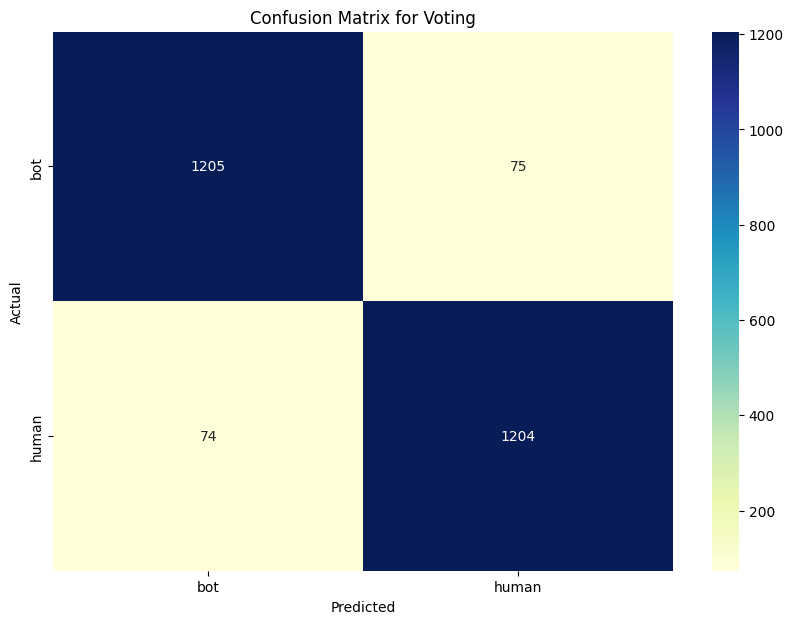

Stacking - Test Set Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1280
           1       0.94      0.94      0.94      1278

    accuracy                           0.94      2558
   macro avg       0.94      0.94      0.94      2558
weighted avg       0.94      0.94      0.94      2558



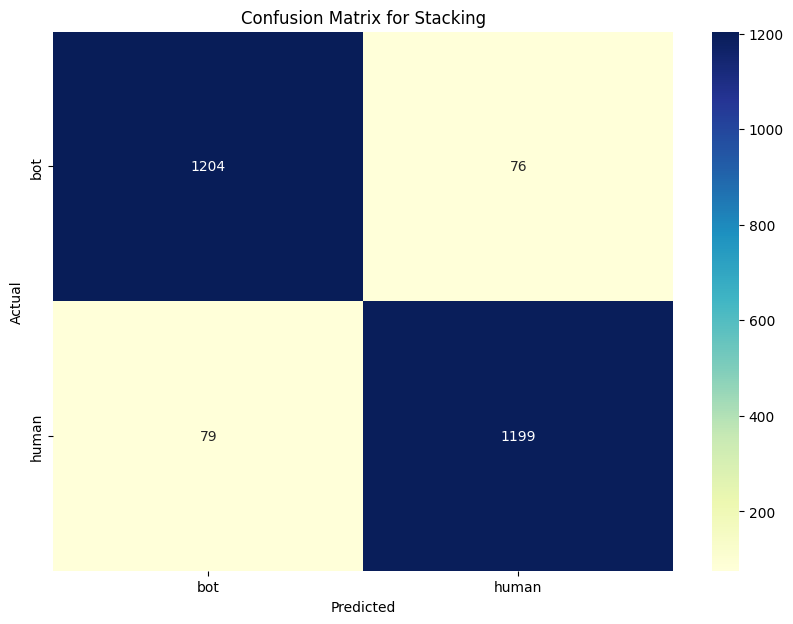

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging - Test Set Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1280
           1       0.83      0.84      0.84      1278

    accuracy                           0.84      2558
   macro avg       0.84      0.84      0.84      2558
weighted avg       0.84      0.84      0.84      2558



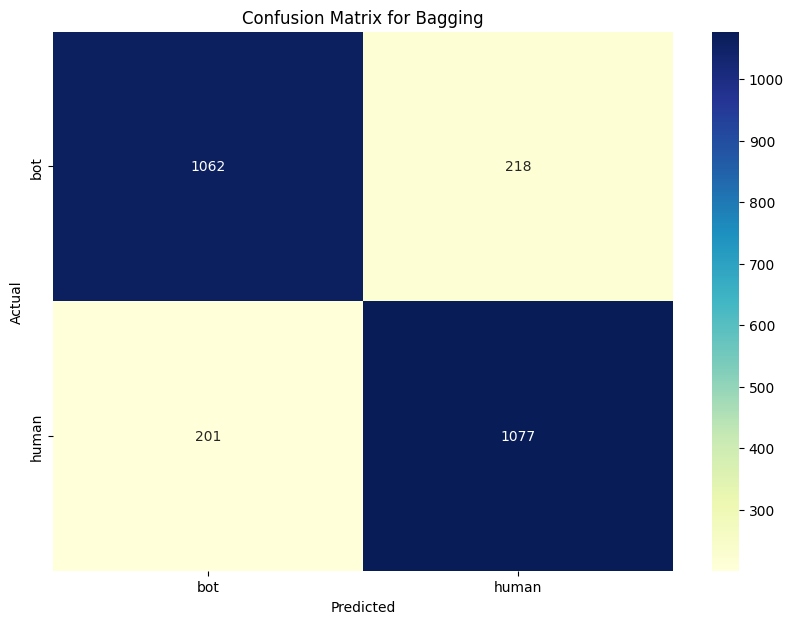

In [12]:
# Ensemble models
print("Evaluating ensemble models:")
ensemble_classifiers = {'Voting': voting_clf, 'Stacking': stacking_clf, 'Bagging': bagging_clf}
for name, clf in ensemble_classifiers.items():
    clf.fit(train_features, train_labels)
    test_pred = clf.predict(test_features)
    print(f"{name} - Test Set Accuracy: {accuracy_score(test_labels, test_pred):.2f}")
    print(classification_report(test_labels, test_pred))
    plot_confusion_matrix(test_labels, test_pred, name)  # Plot confusion matrix for each ensemble model